In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

from modelbase.ode import Simulator

import sys
sys.path.append("../Code")

# Import model functions
from get_current_model import get_model
from function_residuals import calculate_residuals, calculate_residuals_ePathways, integrator_kwargs
from robustness_fit_parameters import get_fitting_parameter_dict, p_names
import functions_light_absorption as lip

Aborted


# Monte Carlo analysis

In [5]:
run = "montecarlo_202405131529"  # Variation by factor 2
# run = "montecarlo_202405141750"  # Variation by +- 10%

# SImulations with different state transition models
# run = "montecarlo_202406061819_mspill"  # Variation by +- 10%
# run = "montecarlo_202406061819_mpbsd"  # Variation by +- 10%


mcpar = pd.read_csv(Path("../Results")/ (run + "_params.csv"), index_col=0)
mcres = pd.read_csv(Path("../Results")/ (run + "_results.csv"), index_col=0)

In [6]:
# Residual functions
residual_names = {
    'LET_fraction' : "LET ~ 65%",
    'LET_flux': "LET ~ 15 e/PSI/s",
    'Schuurmans_O2': "Schuurmans O2 data",
    'Benschop_O2': "Benschop O2 data",
    "PAMSP435_Fm'": "fitting PAM-SP data: Fm'",
    'PAMSP435_left': "fitting PAM-SP data: left Fs",
    'PAMSP435_right': "fitting PAM-SP data: right Fs",
    "PAMSPval_Fm'": "validation PAM-SP data: Fm'",
    'PAMSPval_left': "validation PAM-SP data: left Fs",
    'PAMSPval_right': "validation PAM-SP data: right Fs",
}

In [7]:
# Summary
mcres_outcomes = pd.DataFrame(index=mcres.index, columns=["success", "failed", "time-out"])

mcres_outcomes["timeout"] = np.isnan(mcres).any(axis=1)
mcres_outcomes["failed"] = np.isinf(mcres).any(axis=1)
mcres_outcomes["success"] = mcres_succ = np.invert(np.logical_or(mcres_outcomes["timeout"], mcres_outcomes["failed"]))

print(f"""Full runs: {mcres_outcomes['success'].sum()}
Time-outs: {mcres_outcomes['timeout'].sum()}
Failed: {mcres_outcomes['failed'].sum()}"""
)

Full runs: 9527
Time-outs: 474
Failed: 0


In [20]:
mres_norm.mean(axis=0).mean()

1.5064953777856458

In [21]:
mres_norm = mcres / mcres.loc[0,:]

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

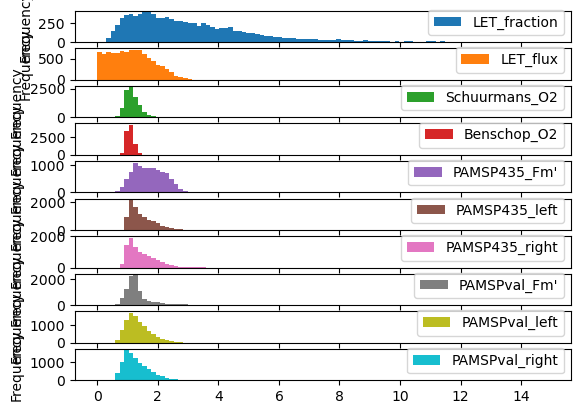

In [22]:
mres_norm.plot(kind="hist", subplots=True, bins=100)

In [23]:
# Find simulations with improved objective functions
mcres_improved = mcres.copy()
mcres_improved = mcres_improved - mcres_improved.iloc[0,:]

# Find simulations with improvement in all objective functions
mcres_outcomes["total_better"] = (mcres_improved < 0).all(axis=1)

# Find simulations with improvement in all objective functions
mcres_outcomes["similar_pareto"] = (mcres_improved < 0.1).all(axis=1)

print(f"""Better runs (all residuals lower): {mcres_outcomes['total_better'].sum()}
Similar runs (all residuals max + 10%): {mcres_outcomes['similar_pareto'].sum()}"""
)

Better runs (all residuals lower): 0
Similar runs (all residuals max + 10%): 19


In [24]:
outcome_sets = {
    "similar_pareto": ["all residuals max 10% higher", "orange"],
    "total_better": ["all residuals improved", "red"],
}

In [25]:
mcpar_flat = mcpar.copy()

# Evaluate the strings in fluo_influence as their dict values are stored as string
# Not a goor practice
mcpar_flat["fluo_influence"] = mcpar_flat["fluo_influence"].apply(eval)

# Unpack the fluo influence parameters 
_fluo_influence = pd.DataFrame(mcpar_flat["fluo_influence"].to_dict()).T
_fluo_influence.columns = "fluo_influence_" + _fluo_influence.columns

# Append them to the parameters
mcpar_flat = pd.concat([mcpar_flat, _fluo_influence], axis=1)
mcpar_flat = mcpar_flat.drop("fluo_influence", axis=1)

In [26]:
# Normalise the parameters
mcpar_fnorm = mcpar_flat.copy()
mcpar_fnorm = mcpar_fnorm / mcpar_fnorm.iloc[0,:]


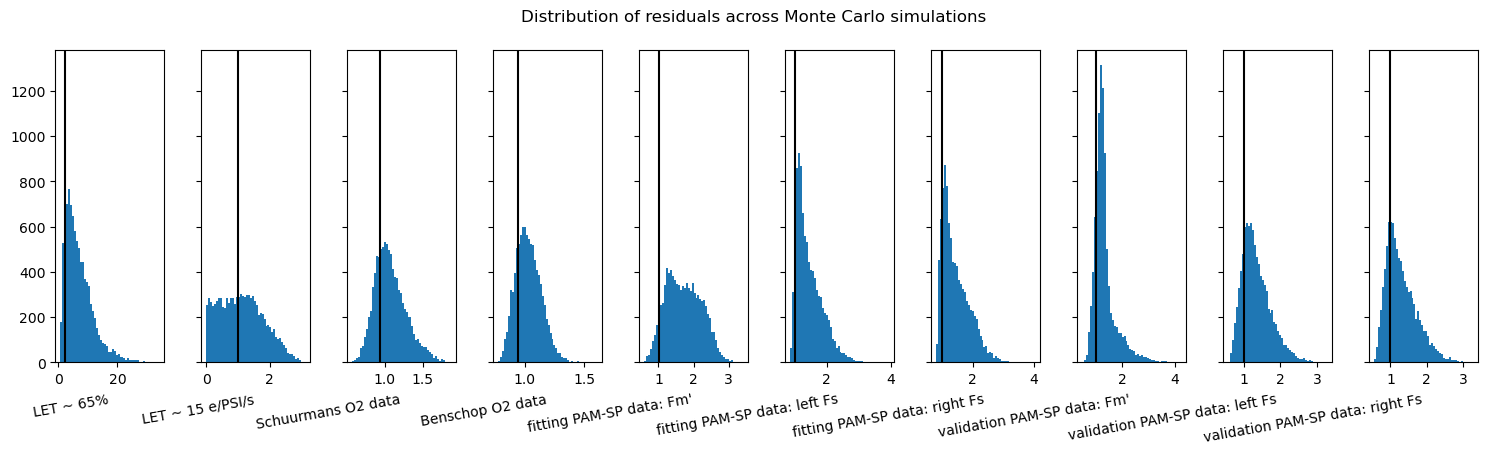

In [27]:
# Visualise the overall distribution

fig, axes = plt.subplots(1, mcres.shape[1], figsize=(15,4), sharey=True)
fig.suptitle("Distribution of residuals across Monte Carlo simulations")

for i, ((nam, val), ax) in enumerate(zip(mcres.T.iterrows(), axes.flatten())):
    ax.hist(val[mcres_succ], bins=50)
    ax.axvline(mcres.loc[0,nam], c="k")

    if i==0:
        fig.tight_layout()
    ax.set_xlabel(residual_names[nam], rotation=10, ha="right")



Text(0.5, 0.89, 'Comparison of residuals across Monte Carlo simulations\n9527 successful simulations with 26 parameters randomly varied within a factor 0.6 higher or lower')

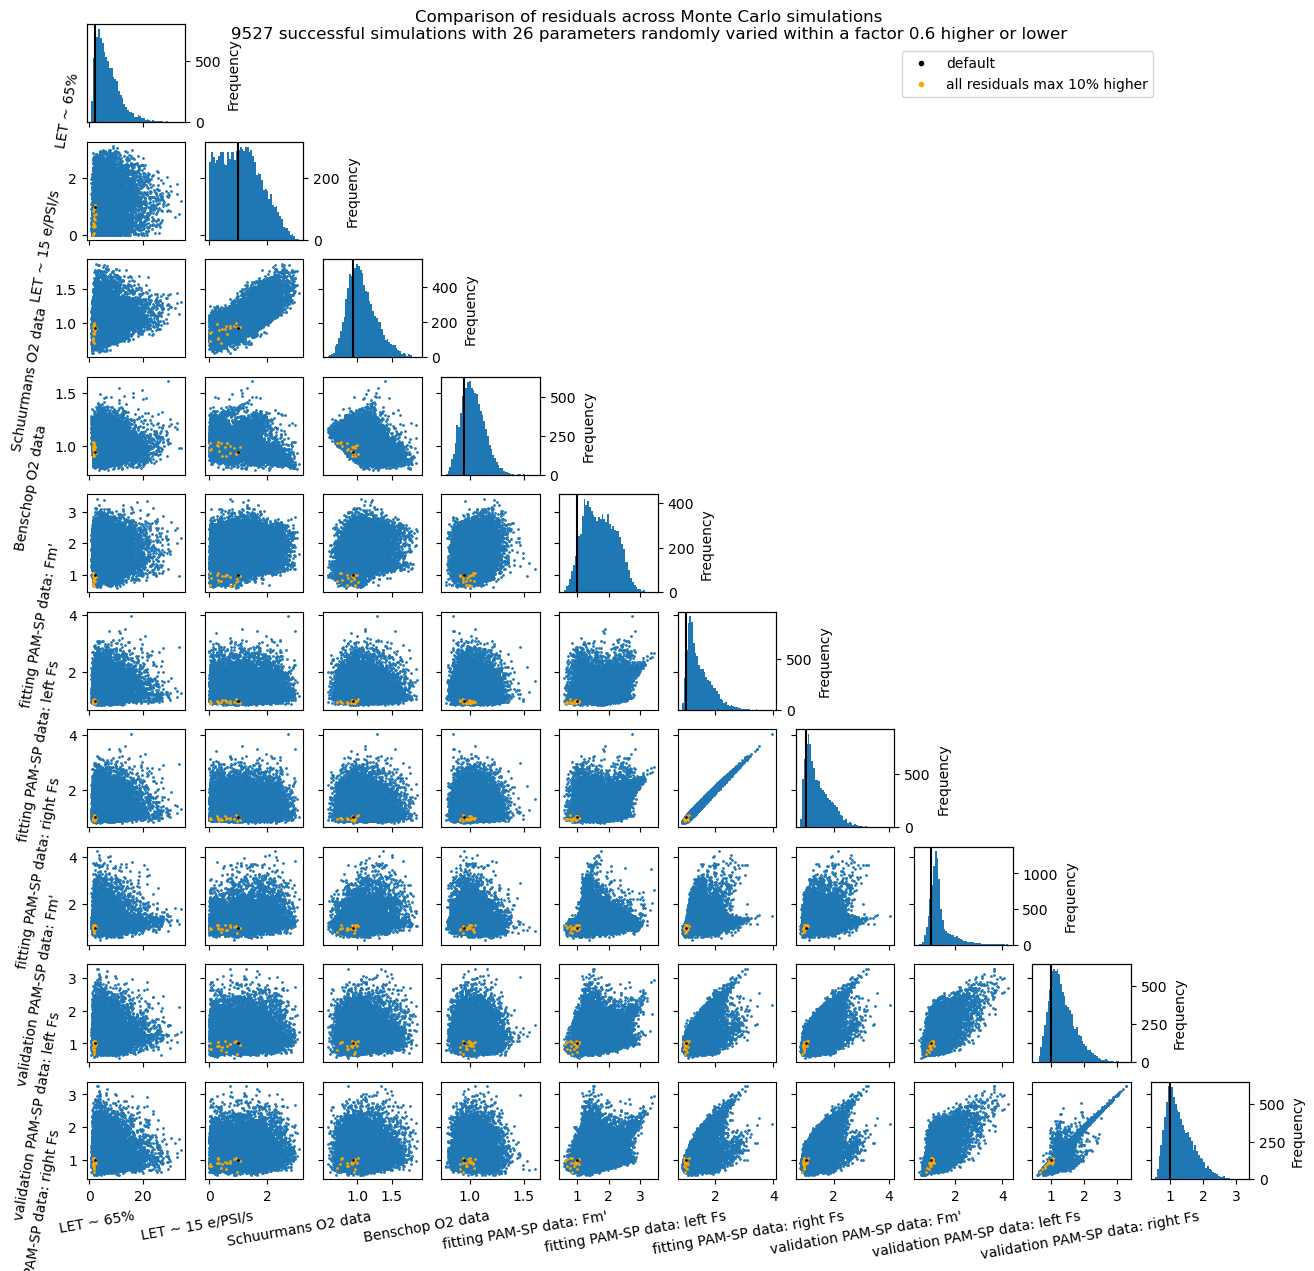

In [28]:
# Plot the pairwise comparison of model objectives
fig, axes = plt.subplots(
    mcres.shape[1],
    mcres.shape[1],
    figsize=(15,15),
    sharey="row",
    sharex="col"
)

# Plot the pariwise comparisons as scatter plots
for i, (nam_i, val_i) in enumerate(mcres.T.iterrows()):
    for j, (nam_j, val_j) in enumerate(mcres.T.iterrows()):
        # On the diagonal plot histograms
        if i==j:
            ax2 = axes[i,j].twinx()
            ax2.hist(val_i[mcres_succ], bins=50)
            ax2.set_ylabel("Frequency")

            # Mark the default
            ax2.axvline(val_i[0], c="k")

        
        # Plot scatter plots of the residuals
        elif i>j:
            axes[i,j].plot(
                val_j,
                val_i,
                marker="o",
                markersize=1,
                linestyle="",
            )

            for res_set in ["similar_pareto", "total_better"]:
            # Highlight the sets close to pareto optimum
                if mcres_outcomes[res_set].any():
                    axes[i,j].plot(
                        val_j[mcres_outcomes[res_set]],
                        val_i[mcres_outcomes[res_set]],
                        marker="o",
                        markersize=1,
                        linestyle="",
                        c=outcome_sets[res_set][1],
                        label=outcome_sets[res_set][0]
                    )

            # Highlight the default set
            axes[i,j].plot(
                val_j[0],
                val_i[0],
                marker="o",
                markersize=1,
                linestyle="",
                c="black",
                label="default"
            )

        else:
            # Remove plots above the diagonal
            axes[i,j].remove()

# Set the y label on the rows and x label on columns
for i in range(mcres.shape[1]):
    axes[i,0].set_ylabel(residual_names[mcres.columns[i]], rotation=80, va="bottom", ha="right")
    axes[-1,i].set_xlabel(residual_names[mcres.columns[i]], rotation=10, ha="right")

# Add a legend
axes[1,0].legend(
    bbox_to_anchor=(10.9,2),
    loc="upper right",
    markerscale=3,
    reverse=True
)

# Remove left axis of first plot
axes[0,0].set_yticks([])

approx_variation_factor = ((mcpar_flat.iloc[:,1].max() - mcpar_flat.iloc[:,1].min()) / 2) / ((mcpar_flat.iloc[:,1].max() + mcpar_flat.iloc[:,1].min()) / 2)
fig.suptitle(f"Comparison of residuals across Monte Carlo simulations\n{mcres_succ.sum()} successful simulations with {mcpar_flat.shape[1]} parameters randomly varied within a factor {np.round(approx_variation_factor,1)} higher or lower", y=0.89)
# fig.tight_layout()

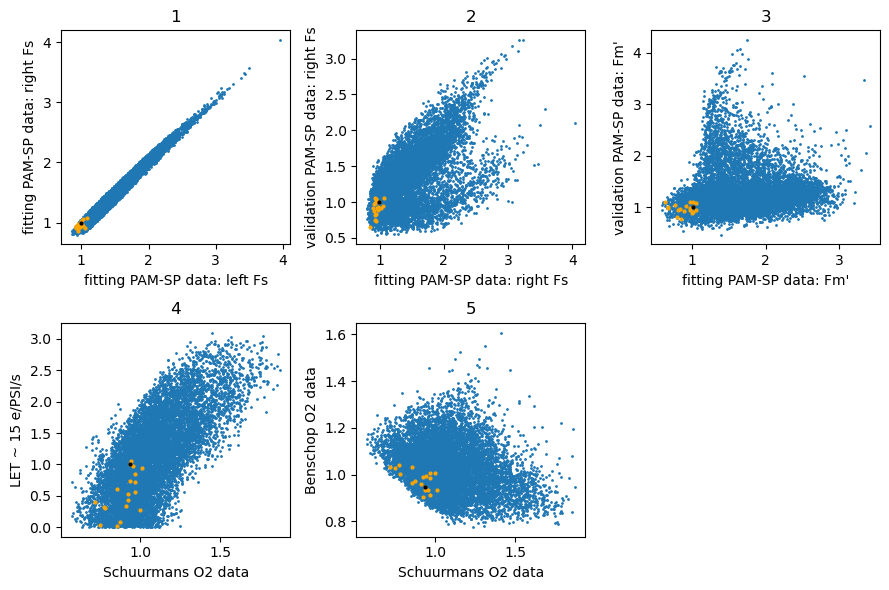

In [29]:
# interesting_pairs = {
#     "The Fs level changes\nas a whole": ["PAMSP435_left", "PAMSP435_right"],
#     # ["PAMSPval_left", "PAMSPval_right"],
#     "The validation Fs is more sensitive to\nperturbations than the validation data": ["PAMSP435_right", "PAMSPval_right"],
#     "The fitted Fm' is more sensitive to\nperturbations than the validation data": ["PAMSP435_Fm'", "PAMSPval_Fm'"],
#     "The fitted LET rate\nreproduces the O2 data best": ["Schuurmans_O2", "LET_flux"],
#     "No parameter set\nimproves both O2 datasets": ["Schuurmans_O2", "Benschop_O2"], 
# }
interesting_pairs = {
    "1": ["PAMSP435_left", "PAMSP435_right"],
    # ["PAMSPval_left", "PAMSPval_right"],
    "2": ["PAMSP435_right", "PAMSPval_right"],
    "3": ["PAMSP435_Fm'", "PAMSPval_Fm'"],
    "4": ["Schuurmans_O2", "LET_flux"],
    "5": ["Schuurmans_O2", "Benschop_O2"], 
}

ncols = 3
nrows = int(np.ceil(len(interesting_pairs)/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

for (descr, pair), ax in zip(interesting_pairs.items(), axes.flatten()):
    # Plot the pairs against eachother
    ax.plot(
        mcres.loc[mcres_succ, pair[0]],
        mcres.loc[mcres_succ, pair[1]],
        marker="o",
        markersize=1,
        linestyle="",
    )
    # Set the axis labels
    ax.set_xlabel(residual_names[pair[0]])
    ax.set_ylabel(residual_names[pair[1]])
    ax.set_title(descr)

    for res_set in ["similar_pareto", "total_better"]:
    # Highlight the sets close to pareto optimum
        if mcres_outcomes[res_set].any():
            ax.plot(
                mcres.loc[mcres_outcomes[res_set], pair[0]],
                mcres.loc[mcres_outcomes[res_set], pair[1]],
                marker="o",
                markersize=2,
                linestyle="",
                c=outcome_sets[res_set][1],
                label=outcome_sets[res_set][0]
            )

    # Highlight the default set
    ax.plot(
        mcres.loc[0, pair[0]],
        mcres.loc[0, pair[1]],
        marker="o",
        markersize=2,
        linestyle="",
        c="black",
        label="default"
    )

# Remove unused axes
if ncols * nrows > len(interesting_pairs):
    for i in range(len(interesting_pairs), ncols * nrows):
        axes.flatten()[i].remove()

fig. tight_layout()

In [30]:
mcpar_flat.shape[1]

26

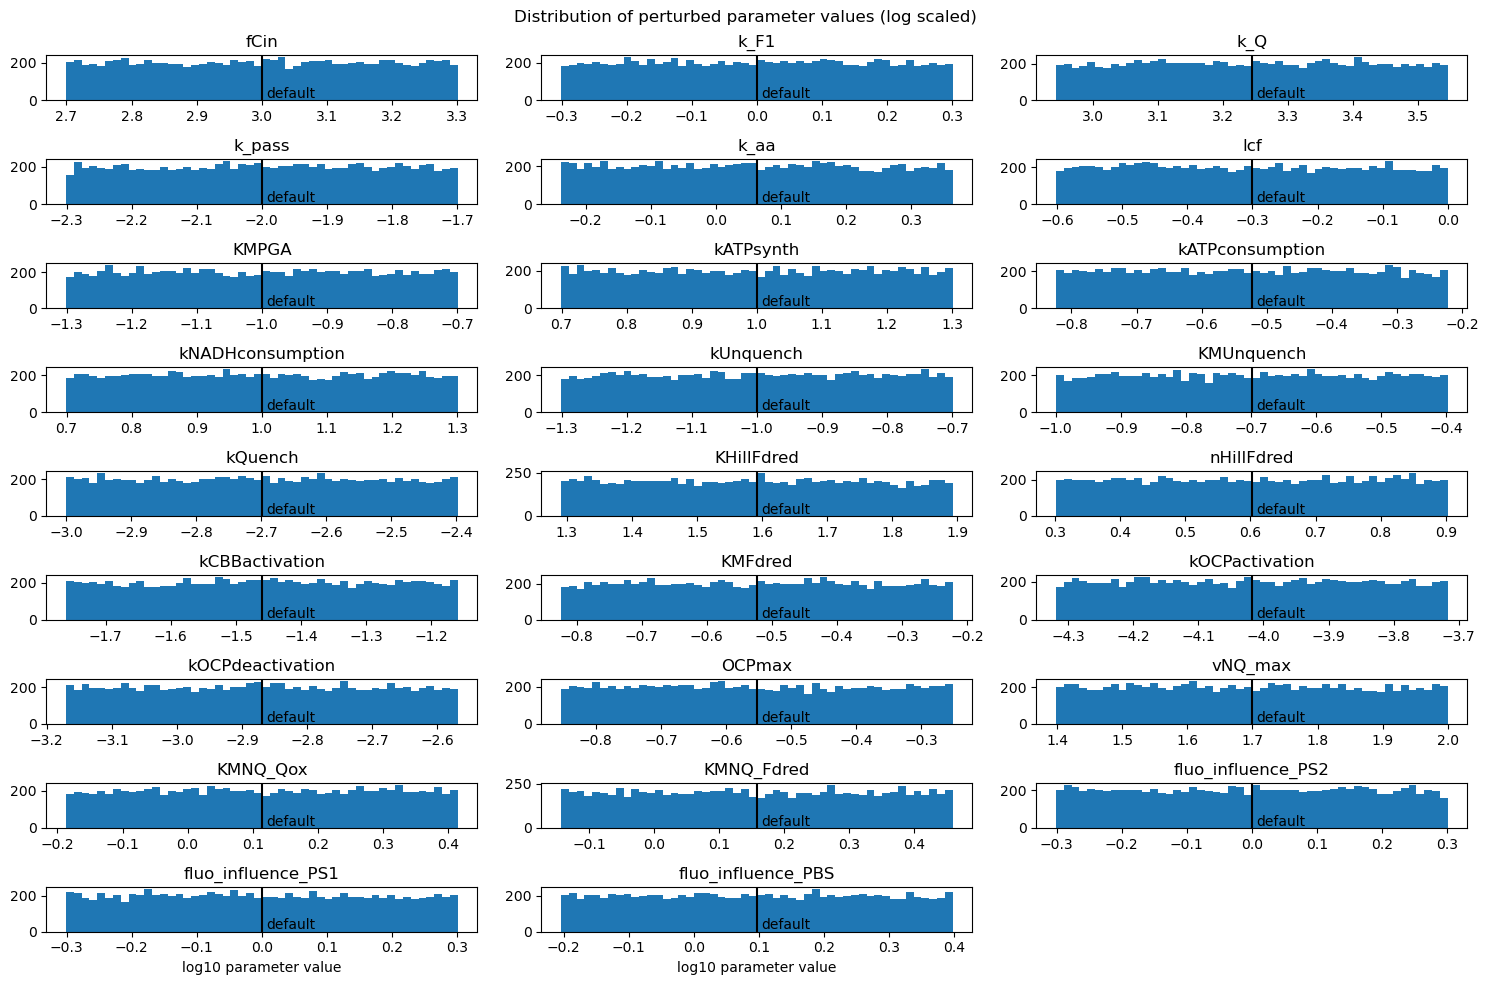

In [31]:
# Plot the parameter distribution
ncols = 3
nrows = int(np.ceil(mcpar_flat.shape[1]/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize = (15,10))

for (nam, val), ax in zip(mcpar_flat.T.iterrows(), axes.flatten()):
    ax.hist(np.log10(val), bins=50)
    ax.set_title(nam)

    ax.axvline(np.log10(val[0]), c="k")
    ax.text(0.51, 0.05, "default", transform = ax.transAxes)

# Label the lowest x axes
for i in range(ncols):
    axes[-1,i].set_xlabel("log10 parameter value")

# Remove unused axes
if ncols * nrows > mcpar_flat.shape[1]:
    for i in range(mcpar_flat.shape[1], ncols * nrows):
        axes.flatten()[i].remove()

fig.suptitle("Distribution of perturbed parameter values (log scaled)")

fig. tight_layout()

In [32]:
# # Visualise with single output
# nrows = 7
# fig, _axes = plt.subplots(nrows, int(np.ceil((mcpar_flat.shape[1]+1) / nrows)), figsize=(15,15))
# axes = _axes.flatten()

# plot_type = "scatter"

# # Plot the overall distribution
# axes[0].hist(mcres[mcres_succ], bins=100, orientation="horizontal")
# axes[0].set_xlabel("Frequency")

# for i, (nam, vals) in enumerate(mcpar_flat.T.iterrows()):

#     if plot_type == "scatter":
#         axes[i+1].plot(
#             vals[mcres_succ],
#             mcres[mcres_succ],
#             marker="o",
#             ls="",
#             markersize=1
#         )
#         axes[i+1].set_xscale("log")
#     elif plot_type == "hex":
#         axes[i+1].hexbin(
#             np.log10(vals[mcres_succ]),
#             mcres[mcres_succ],
#         )

#     # axes[i+1].plot(
#     #     vals[0],
#     #     mcres[0],
#     #     marker="o",
#     #     ls="",
#     #     markersize=3,
#     #     c="red"
#     # )

#     axes[i+1].set_xlabel(nam)

# # Add the y label
# _axes[nrows//2, 0].set_ylabel("Root mean squared residuals [AU]")

# # Add a title and improve the layout
# fig.suptitle("Residuals under parameter variation")
# fig.tight_layout()


# plt.show(fig)
# plt.close()

## Visualisation for paper

Text(0.5, 0.93, 'Distribution of residuals in Monte Carlo simulations\n9527 simulations with 26 parameters randomly varied within a factor 0.6 higher or lower')

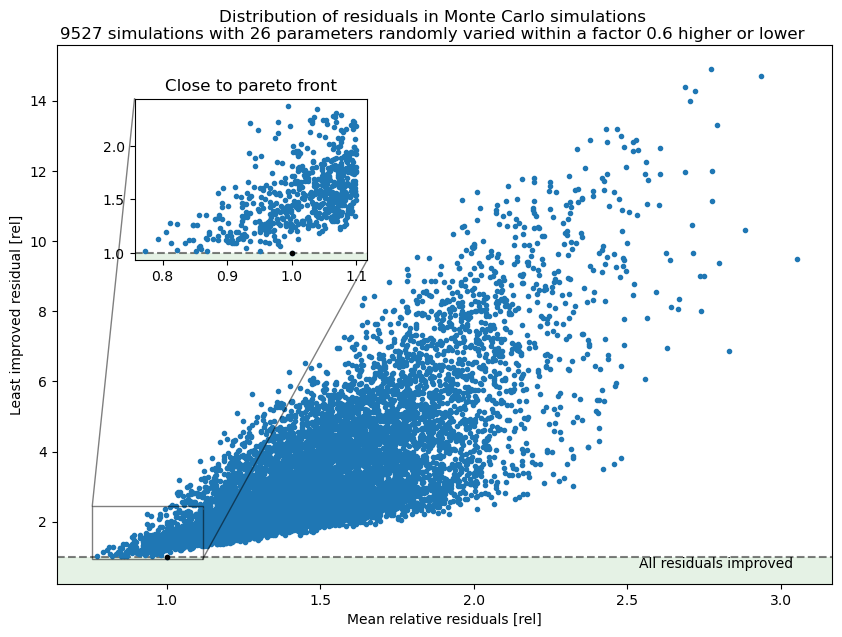

In [33]:
mcres_norm = mcres / mcres.loc[0, :]

# Get the worst improvement
mcres_worst = mcres_norm.max(axis=1)
mcres_mean = mcres_norm.mean(axis=1)

fig, ax = plt.subplots(figsize = (10,7))

# Zoom to the pareto front
point_select = np.logical_and(
    mcres_mean < 1.1,  
    mcres_worst < (mcres_worst.min() + (mcres_worst.max() - mcres_worst.min()) * 0.1)
)

axin = ax.inset_axes(
    [0.1, 0.6, 0.3, 0.3],)
    # xlim=(0.5, 1.1), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axin.set_title("Close to pareto front")

for _ax, _point_select in zip([ax, axin], [slice(None), point_select]):
    # Indicate the area of improvement
    _ax.axhline(1, ls="--", c="k", alpha=0.5)
    # _ax.axhspan(0.5, 1, facecolor="green", alpha=0.1)
    _ax.add_artist(plt.Rectangle((0.5, 0), 6, 1, alpha=0.1, zorder=1, facecolor="green"))

    # Plot the distribution of residuals
    _ax.plot(
        mcres_mean[_point_select],
        mcres_worst[_point_select],
        ls = "",
        marker = "."
        )
    # Show the default parameter set
    _ax.plot(
        mcres_mean[0],
        mcres_worst[0],
        ls = "",
        marker = ".",
        c="k"
        )

ax.indicate_inset_zoom(axin, edgecolor="black")
ax.text(0.95, 0.05, "All residuals improved", ha="right", va="top", transform=ax.transAxes)

ax.set_xlabel("Mean relative residuals [rel]")
ax.set_ylabel("Least improved residual [rel]")

# Calculate the approximate factor by which the parameters were varied
approx_variation_factor = ((mcpar_flat.iloc[:,1].max() - mcpar_flat.iloc[:,1].min()) / 2) / ((mcpar_flat.iloc[:,1].max() + mcpar_flat.iloc[:,1].min()) / 2)
fig.suptitle(f"Distribution of residuals in Monte Carlo simulations\n{mcres_succ.sum()} simulations with {mcpar_flat.shape[1]} parameters randomly varied within a factor {np.round(approx_variation_factor,1)} higher or lower", y=0.93)

## PCA

In [35]:
mcres.tail()

,LET_fraction,LET_flux,Schuurmans_O2,Benschop_O2,PAMSP435_Fm',PAMSP435_left,PAMSP435_right,PAMSPval_Fm',PAMSPval_left,PAMSPval_right
9996,2.312673,0.336977,0.664542,1.082220,1.599892,1.071205,1.076830,1.262842,1.118510,1.110133
9997,2.739030,0.529275,0.873141,1.139715,1.568843,1.086207,1.128294,1.242108,1.036083,1.037121
9998,2.388445,0.955666,1.189490,1.125010,1.546710,1.597607,1.625683,1.077532,1.450999,1.487585
9999,3.367947,0.270820,1.079409,0.937396,1.792481,1.086385,1.132042,1.082569,1.178909,0.947355
10000,11.707466,0.563988,0.799257,1.082026,1.188159,1.903942,2.019826,0.971193,1.840543,1.825862


In [ ]:
mcres_succ

In [47]:
from sklearn.preprocessing import StandardScaler
x = mcres.loc[mcres_succ].values
x = StandardScaler().fit_transform(x) # normalizing the features

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
mcres_pcanorm = pd.DataFrame(x,columns=feat_cols)

from sklearn.decomposition import PCA
mcres_pca = PCA(n_components=3)
mcres_pcs = mcres_pca.fit_transform(x)
mcres_pcs = pd.DataFrame(mcres_pcs, columns=[f"PC{i} ({x:.2f} %)" for i,x in enumerate(mcres_pca.explained_variance_ratio_ * 100)])

print('Explained variation per principal component: {}'.format(mcres_pca.explained_variance_ratio_))

Explained variation per principal component: [0.34278803 0.19806348 0.12116644]


In [48]:
mcres_pcs

,PC0 (34.28 %),PC1 (19.81 %),PC2 (12.12 %)
0,-2.209206,-0.422916,-1.510478
1,-2.097421,-1.877169,-0.762140
2,-0.635258,-0.381873,0.045642
3,2.335175,0.325563,1.051542
4,1.782845,-0.418622,-0.891224
...,...,...,...
9522,-1.629606,-1.991511,-0.283916
9523,-1.690561,-1.371335,0.172114
9524,0.427000,-0.506663,0.416682
9525,-1.570739,-0.358599,-0.432672


In [96]:
X, Y, Z = mcres_pcs.T.values

pcs_select = mcres_outcomes["similar_pareto"][mcres_succ]

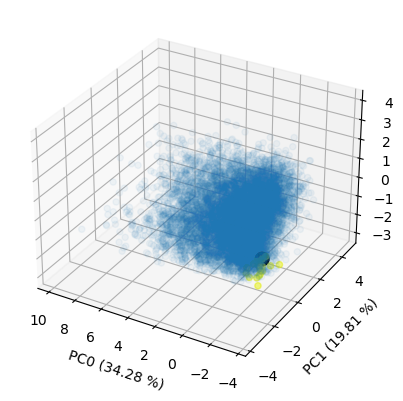

In [158]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, alpha=0.05)

# Mark special points
ax.scatter3D(X[pcs_select], Y[pcs_select], Z[pcs_select], c="yellow", ls="", marker="o", alpha=0.5)
ax.scatter3D(X[0], Y[0], Z[0], c="k", ls="", marker="o", s=100)

ax.set_xlabel(mcres_pcs.columns[0])
ax.set_ylabel(mcres_pcs.columns[1])
ax.set_zlabel(mcres_pcs.columns[2])

ax.xaxis.set_inverted(True)
# ax.yaxis.set_inverted(True)
# ax.zaxis.set_inverted(True)
# ax.view_init(0, 0)

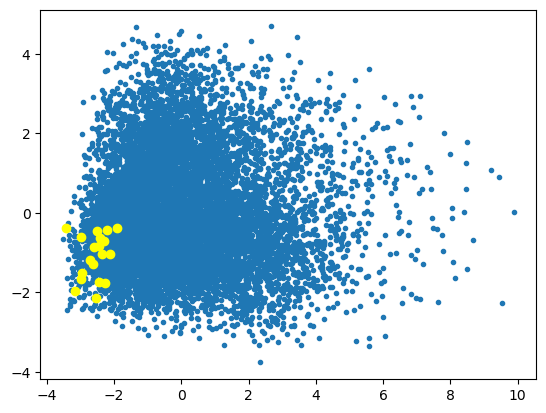

In [135]:
fig, ax = plt.subplots()
ax.plot(X,Y, ls="", marker=".")
ax.plot(X[pcs_select], Y[pcs_select], c="yellow", ls="", marker="o")

TypeError: Input z must be 2D, not 1D

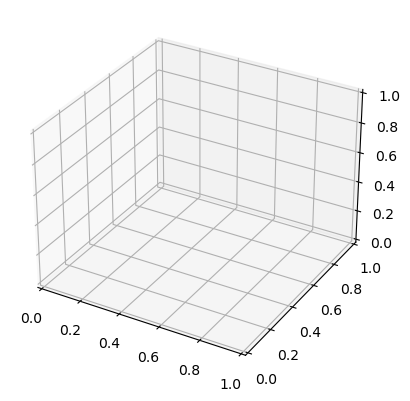

In [61]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(*mcres_pcs.iloc[:, [1,2,0]].T.values)
ax.contour3D(*mcres_pcs.iloc[:, [1,2,0]].T.values, 50, cmap='binary')

In [ ]:
fig, ax = plt.subplot()

# Local optimisation

In [121]:
with open("../Results/minimise_202405291906_results.pickle", "rb") as f:
    fit = pickle.load(f)

In [123]:
p_optim = get_fitting_parameter_dict(fit.x, p_names)

In [124]:
test = calculate_residuals(p_optim, save_intermediates=False, return_all=True)

In [128]:
test[1].median()

0.8061179278216299

In [ ]:
residuals = pd.DataFrame(index=np.arange(7), columns=[1,2,3])

In [ ]:
test = pd.Series({1:2, 2:4, 3:6})
test2 = pd.Series({2:"a", 3:"b", 1:"c"})

In [ ]:
from pathlib import Path

In [ ]:
Path("../Results/202404171132_CO2production_wi.dill").is_file()

In [ ]:
test

In [ ]:
",".join(test.values.astype(str))

In [ ]:
residuals.loc[0,:] = test

In [ ]:
residuals.loc[1,:] = test2

In [ ]:
residuals